# FASTSim Demonstration

![fastsim icon](fastsim-icon-web-131x172.jpg)

Developed by NREL, the Future Automotive Systems Technology Simulator (FASTSim) evaluates the impact of technology improvements on efficiency, performance, cost, and battery life in conventional vehicles, hybrid electric vehicles (HEVs), plug-in hybrid electric vehicles (PHEVs), and all-electric vehicles (EVs).

FASTSim answers questions such as:
- Which battery sizes are most cost effective for a PHEV or EV?
- At what battery prices do PHEVs and EVs become cost effective?
- On average, how much fuel does a PHEV with a 30-mile electric range save?
- How much fuel savings does an HEV provide for a given drive cycle?
- How do lifetime costs and petroleum use compare for conventional vehicles, HEVs, PHEVs, and EVs?

FASTSim was originally implemented in Microsoft Excel. The pythonic implementation of FASTSim, demonstrated here, captures the drive cycle energy consumption simulation component of the software. The python version of FASTSim is more convenient than the Excel version when very high computational speed is desired, such as for simulating a large batch of drive cycles.

In [81]:
import sys
import os
from pathlib import Path
# allow it to find simdrive module
fsimpath=str(Path(os.getcwd()).parents[0])
if fsimpath not in sys.path:
    sys.path.append(fsimpath)
import numpy as np
from scipy.integrate import cumtrapz
import time
import pandas as pd
import importlib
import matplotlib.pyplot as plt
import importlib
import math
import seaborn as sns
sns.set()

%matplotlib inline

In [82]:
# local modules
from fastsim import simdrive, vehicle, cycle
from fastsim import parameters as params
from fastsim import utilities as utils
# importlib.reload(simdrive)
# importlib.reload(cycle)

# Coastdown validation/tuning

In [83]:
# get the data
raw_df = pd.read_csv(r'C:\Users\cbaker2\Documents\Projects\FASTSim'+
                     '\MDHD\Isuzu NPR HD Boxtruck coastdown.csv', header=None)
raw_df.columns = ['Time [s]', 'Speed [mph]']

In [84]:
# split it up into the two separate curves for each cd direction
north_cut = np.argmax(raw_df.iloc[1:, 0].values < raw_df.iloc[:-1, 0].values)
north_df = raw_df.iloc[:north_cut]
south_df = raw_df.iloc[north_cut+1:]

In [85]:
# polynomial fit
p_coeffs_n = np.polyfit(north_df['Time [s]'], north_df['Speed [mph]'], 3)
poly_n = np.poly1d(p_coeffs_n)
p_coeffs_s = np.polyfit(south_df['Time [s]'], south_df['Speed [mph]'], 3)
poly_s = np.poly1d(p_coeffs_s)

Text(0, 0.5, 'Speed [mph]')

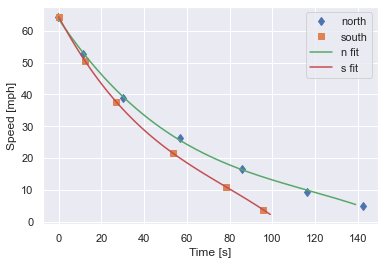

In [86]:
ax = north_df.plot(x='Time [s]', y='Speed [mph]', label='north', linestyle='', marker='d')
south_df.plot(x='Time [s]', y='Speed [mph]', ax=ax, label='south', linestyle='', marker='s')
plt.plot(np.arange(140), poly_n(np.arange(140)), label='n fit')
plt.plot(np.arange(100), poly_s(np.arange(100)), label='s fit')
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Speed [mph]')
# plt.grid()

## Checking northbound coastdown match

In [87]:
cyc_n = cycle.Cycle(cyc_dict=
        {'cycSecs':np.arange(140), 'cycMps':poly_n(np.arange(140)) / params.mphPerMps, 
        'cycGrade':np.concatenate([np.ones(105) * -0.4 / 100, np.zeros(25)])})
cyc_n_jit = cyc_n.get_numba_cyc()

veh = vehicle.Vehicle(veh_file='../vehdb/Class 4 Truck.csv')
veh_jit = veh.get_numba_veh()

simdrive_n = simdrive.SimDriveJit(cyc_n_jit, veh_jit)
simdrive_n.mpsAch[0] = cyc_n.cycMps[0]
simdrive_n.sim_drive()

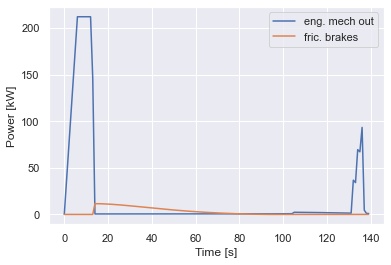

In [88]:
plt.figure()
plt.plot(cyc_n.cycSecs, simdrive_n.fcKwOutAch, label='eng. mech out')
plt.plot(cyc_n.cycSecs, simdrive_n.cycFricBrakeKw, label='fric. brakes')
plt.xlabel('Time [s]')
plt.ylabel('Power [kW]')
plt.legend()
# plt.grid()

Text(0, 0.5, 'Speed [mph]')

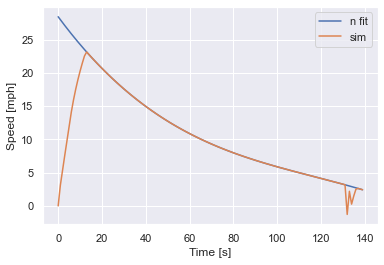

In [89]:
plt.plot(np.arange(140), poly_n(np.arange(140)) / params.mphPerMps, label='n fit')
plt.plot(cyc_n.cycSecs, simdrive_n.mpsAch, label='sim')
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Speed [mph]')
# plt.grid()

## Checking southbound coastdown match

In [90]:
cyc_s = cycle.Cycle(cyc_dict=
        {'cycSecs':np.arange(100), 'cycMps':poly_s(np.arange(100)) / params.mphPerMps, 
        'cycGrade':np.concatenate([np.zeros(25), np.ones(105) * 0.4 / 100])})
cyc_s_jit = cyc_s.get_numba_cyc()

veh = vehicle.Vehicle(veh_file='../vehdb/Class 4 Truck.csv')
veh_jit = veh.get_numba_veh()
simdrive_s = simdrive.SimDriveJit(cyc_s_jit, veh_jit)
simdrive_s.mpsAch[0] = cyc_s.cycMps[0]
simdrive_s.sim_drive()

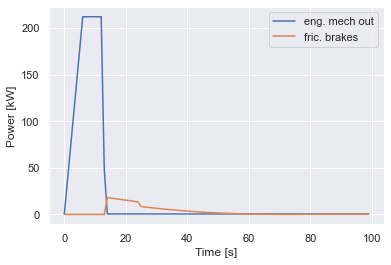

In [91]:
plt.figure()
plt.plot(cyc_s.cycSecs, simdrive_s.fcKwOutAch, label='eng. mech out')
plt.plot(cyc_s.cycSecs, simdrive_s.cycFricBrakeKw, label='fric. brakes')
plt.xlabel('Time [s]')
plt.ylabel('Power [kW]')
plt.legend()
# plt.grid()

Text(0, 0.5, 'Speed [mph]')

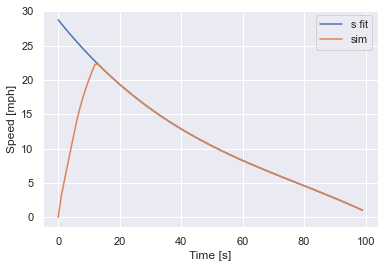

In [92]:
plt.plot(np.arange(100), poly_s(np.arange(100)) / params.mphPerMps, label='s fit')
plt.plot(cyc_s.cycSecs, simdrive_s.mpsAch, label='sim')
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Speed [mph]')
# plt.grid()

# Validating Against Test Data
Reasonable weight range for class 4: (6,351–7,257 kg)

In [93]:
# functions for things that will be done repeatedly
def rollav(data, width):
    out = np.zeros(len(data))
    for i in range(len(data)):
        if i < width:
            out[i] = data[:i].mean()
        else:
            out[i] = data[i-width:i].mean()
    return out

def plot_speed(sd, df, ax2):
    ax2.plot(sd.cyc.cycSecs, sd.mphAch, label='FASTSim')
    ax2.plot(sd.cyc.cycSecs, df['Speed[mps]'] * 2.2, label='test', linestyle='--', alpha=0.75)
    ax2.set_xlabel('Time [s]')
    ax2.set_ylabel('Speed [mph]')
    ax2.legend()
#     ax2.grid()

def plot_fuel_power(sd, df, save_name=None, roll_width=10):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

    ax1.plot(sd.cyc.cycSecs, rollav(sd.fcKwInAch, roll_width), label='FASTSim')
    ax1.plot(sd.cyc.cycSecs, df['Fuel Power [kW]'], label='test')
    # ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('Fuel Power [kW]')
    ax1.legend()
#     ax1.grid()
    
    plot_speed(sd, df, ax2)

    if save_name:
        fig.savefig(save_name + ' fuel kW.svg')
    
def plot_fuel_energy(sd, df, save_name=None):
    e_fuel_test = np.trapz(df['Fuel Power [kW]'], df['time[s]']) / 1e3
    e_fuel_sim = np.trapz(sd.fcKwInAch / 1e3, sd.cyc.cycSecs)
    print('Total fuel in test: {:.3f} MJ'.format(e_fuel_test))
    print('Total fuel in FASTSim: {:.3f} MJ'.format(e_fuel_sim))
    sign = 'higher' if e_fuel_sim > e_fuel_test else 'lower'
    print("FASTSim is {:.2%} ".format((e_fuel_sim - e_fuel_test) / e_fuel_test) + sign + " than test.\n")
    
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

    ax1.plot(sd.cyc.cycSecs[1:], cumtrapz(y=sd.fcKwInAch / 1e3, x=sd.cyc.cycSecs),
             label='FASTSim')
    ax1.plot(sd.cyc.cycSecs[1:], cumtrapz(y=df['Fuel Power [kW]'] / 1e3, x=df['time[s]']),
             label='test')
    # ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('Fuel Energy [MJ]')
    ax1.legend()
#     ax1.grid()
    
    plot_speed(sd, df, ax2)
    
    if save_name:
        fig.savefig(save_name + ' fuel MJ.svg')

def plot_eng_power(sd, df, save_name=None, roll_width=10):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

    ax1.plot(sd.cyc.cycSecs, rollav(sd.fcKwOutAch, roll_width), label='FASTSim')
    ax1.plot(sd.cyc.cycSecs, df['Eng Power [kW]'], label='test')
    # ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('Eng Power [kW]')
    ax1.legend()
#     ax1.grid()
    
    plot_speed(sd, df, ax2)

    if save_name:
        fig.savefig(save_name + ' eng kW.svg')
    
def plot_eng_energy(sd, df, save_name=None):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

    ax1.plot(sd.cyc.cycSecs[1:], cumtrapz(y=sd.fcKwOutAch / 1e3, x=sd.cyc.cycSecs),
             label='FASTSim')
    ax1.plot(sd.cyc.cycSecs[1:], cumtrapz(y=df['Eng Power [kW]'] / 1e3, x=df['time[s]']),
             label='test')
    # ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('Cumulative\n' + 'Eng Energy [MJ]')
    ax1.legend()
#     ax1.grid()
    
    plot_speed(sd, df, ax2)
    
    if save_name:
        fig.savefig(save_name + ' eng MJ.svg')
    

In [94]:
# constants
rho_diesel = 0.832 # https://en.wikipedia.org/wiki/Diesel_fuel
lhv_diesel = 42.6e3 # [kJ/kg] https://www.engineeringtoolbox.com/fuels-higher-calorific-values-d_169.html
h_Denver = 1609 # altitude [m] of Denver 
rho_air_Denver, p, T_standard = utils.get_rho_air(h_Denver, 22, full_output=True)

Y:\5400\ReFUEL\Projects\1 Archived Projects\2015_Carb Aero\Data\on-road\Isuzu\test.csv

In [95]:
df_isuzu = pd.read_csv('../cycles/Isuzu_test_formatted.csv')
df_isuzu['Fuel Power [kW]'] = df_isuzu['EngFuelRate[l/h]'] / 3600 * rho_diesel * lhv_diesel
df_isuzu['Speed[mps]'] = df_isuzu['gps_Speed[km/h]'].values * 0.278
df_isuzu['Eng Torque [N*m]'] = df_isuzu['EngReferenceTorque[-]'] * df_isuzu['EngPercentTorque_ACT[%]'] / 100
df_isuzu['Eng Power [kW]'] = df_isuzu['Eng Torque [N*m]'] * df_isuzu['EngSpeed[RPM]'] / 60 * 2 * np.pi / 1e3
df_isuzu['Eng Eff [-]'] = df_isuzu['Eng Power [kW]'] / df_isuzu['Fuel Power [kW]']

In [96]:
cyc_isuzu = cycle.Cycle(
    cyc_dict={'cycSecs':df_isuzu['time[s]'].values, 
              'cycMps':df_isuzu['Speed[mps]'].values})\
    .get_numba_cyc()

# Source for weight: https://www.isuzucv.com/en/app/site/pdf?file=n_brochure.pdf
veh = vehicle.Vehicle(veh_file='../vehdb/Class 4 Truck.csv')
veh.vehKg = 6145 / 2.205 # empty truck weight
veh.auxKw = 0.3
veh_jit = veh.get_numba_veh()

sd_isuzu = simdrive.SimDriveJit(cyc_isuzu, veh_jit)
sd_isuzu.props.airDensityKgPerM3 = rho_air_Denver 
sd_isuzu.sim_drive()

Total fuel in test: 16.067 MJ
Total fuel in FASTSim: 16.218 MJ
FASTSim is 0.94% higher than test.



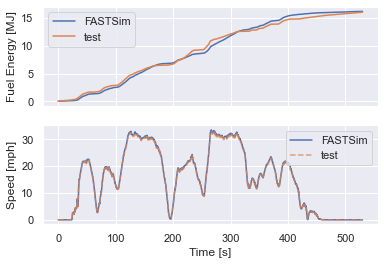

In [97]:
plot_fuel_energy(sd_isuzu, df_isuzu, save_name='fastim vs isuzu test')

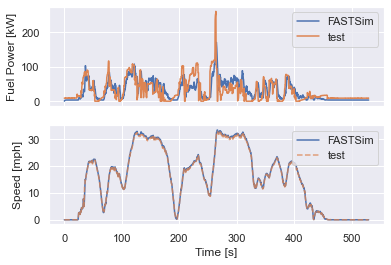

In [98]:
plot_fuel_power(sd_isuzu, df_isuzu, save_name='fastim vs isuzu test', roll_width=10)

In [99]:
print('Total engine energy in test: {:.3f} MJ'.format(
    np.trapz(df_isuzu['Eng Power [kW]'], df_isuzu['time[s]']) / 1e3))
print('Total engine energy in FASTSim: {:.3f} MJ'.format(np.trapz(sd_isuzu.fcKwOutAch / 1e3, cyc_isuzu.cycSecs)))

Total engine energy in test: 5.154 MJ
Total engine energy in FASTSim: 3.880 MJ


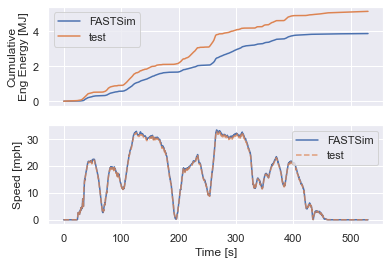

In [100]:
plot_eng_energy(sd_isuzu, df_isuzu, save_name='fastim vs isuzu test')

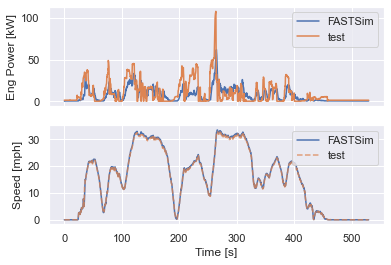

In [101]:
plot_eng_power(sd_isuzu, df_isuzu, save_name='fastim vs isuzu test', roll_width=10)

Y:\5400\ADV_VEH_INFRA\Fleet Test and Evaluation\Projects\2017 CARB Voc Aero\Data\A1_Truck_Rental\I17_CARB-Aero_Rental_5P36767

In [102]:
# code for loading data from Y drive

# only load the data if not already loaded
try:
    len(data2d) 
except:
    topdir = r'Y:\5400\ADV_VEH_INFRA\Fleet Test and Evaluation\Projects\2017 CARB Voc Aero\Data'
    # datadir = topdir + r'\A1_Truck_Rental\I17_CARB-Aero_Rental_5P36767' # no fuel flow
    # datadir = topdir + r'\Dy_Dee_Laudry_Service\I11_CARB-Aero_Laundry_Service_60007M2' # no fuel flow
    # datadir = topdir + r'\Coachella_Valley_Water_District\I7_CARB-Aero_Work_Truck_2400' # no fuel flow
    # datadir = topdir + r'\Coachella_Valley_Water_District\I20_CARB-Aero_Work_Truck_2437'  # no fuel flow
    datadir = topdir + r'\TeeVax\I18_CARB-Aero_Appliance Delivery_104'

    files = [file for file in 
             os.listdir(datadir) 
             if 'SEGMENT' in file]

    with open(datadir + '\\' + files[0], 'r') as file:
        data = file.readlines()
        data0list = data[0].split(',')
        data1list = data[1].split(',')

        header = ''
        for i, (d0, d1) in enumerate(zip(data0list, data1list)):
            header += d0 + ' [' + d1 + '],'
        header.replace('\n', '')
        header = header[:-1]
        columns = header.split(',')


    data2d = []
    last_segment = len(files) // 2
    print_prog = [10] # greater than zero triggers print at start
    for i in range(last_segment):
        print_prog.append(np.floor(i / last_segment * 100) % 20)
        if print_prog[-1] < print_prog[-2]:
            print('{:.0%} complete loading'.format(i / last_segment))
            print(f'Loading data from {files[i]}')
        with open(datadir + '\\' + files[i], 'r') as file:
            data = file.readlines()
            for i, row in enumerate(data[5:]):
                data2d.append(row.replace('\n', '').split(','))

In [103]:
df = pd.DataFrame(data2d, columns=columns)
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='ignore')

df['Speed [mph]'] = df['gps_Speed [km/h]'] / 1.61
df['Fuel Power [kW]'] = df['EngFuelRate [l/h]'] / 3600 * rho_diesel * lhv_diesel
df['Speed[mps]'] = df['gps_Speed [km/h]'].values * 0.278
df['time[s]'] = df['time [s]']

time_jumps = np.where(df['time [s]'].values[1:] < df['time [s]'].values[:-1])[0]
max_good_time_start = time_jumps[np.argmax(np.diff(time_jumps))] + 1
max_good_time_end = time_jumps[np.argmax(np.diff(time_jumps)) + 1]
         
df = df.iloc[max_good_time_start:max_good_time_end]
df.reset_index(inplace=True, drop=True)
# df['Fuel Power [kW]'] = df['EngFuelRate[l/h]'] / 3600 * rho_diesel * lhv_diesel

In [104]:
cyc_cust = cycle.Cycle(
    cyc_dict={'cycSecs':df['time[s]'].values, 
              'cycMps':df['Speed[mps]'].values})\
    .get_numba_cyc()

veh_jit.auxKw = 2 # this provides a good offset for idle times
sd_cust = simdrive.SimDriveJit(cyc_cust, veh_jit)
sd_cust.sim_drive()

Total fuel in test: 315.482 MJ
Total fuel in FASTSim: 306.328 MJ
FASTSim is -2.90% lower than test.



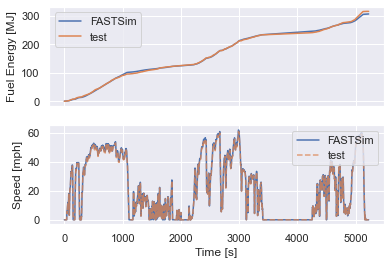

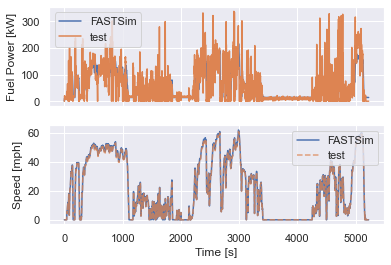

In [105]:
plot_fuel_energy(sd_cust, df, 'TeeVax')
plot_fuel_power(sd_cust, df, 'TeeVax')